# Evaluation of Rate of Hospital Admission Related to Infections

In this notebook, we evaluate the rate of hospital admission related to common infections, including upper respiratory tract infection (URTI), lower respiratory tract infection (LRTI), urinary tract infection (UTI).

In [34]:
import pandas as pd
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import os
import glob
import gzip
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from lifelines import CoxPHFitter
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import pickle
from sklearn.preprocessing import PolynomialFeatures
from lifelines.utils import k_fold_cross_validation
from lifelines.utils import concordance_index
from lifelines.calibration import survival_probability_calibration
from sklearn.model_selection import train_test_split
import io
import sys
from contextlib import redirect_stdout
# %matplotlib inline

In [35]:
#os.chdir("..")
current_working_dir = os.getcwd()
print(current_working_dir)

# !python --version
# import sklearn
# print(sklearn.__version__)
# import lifelines
# print(lifelines.__version__)

c:\Users\m84300af\OneDrive - The University of Manchester\Documents\GitHub\amr-uom-brit\analysis


In [36]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

No Warning Shown


## 0- Functions

In [37]:
def create_histplot(title, df, ax):
    ax.hist(df, color = 'purple', edgecolor = 'black', bins=20)
    ax.set_title(title)
    ax.set_ylabel('Frequency')
    ax.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=0)

In [38]:
def create_lineplot(data, var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    a.Freq = a.Freq /1000
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count in 1000 patients')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

In [39]:
# function to transform cph model summary and save it as html
def GetPrintSummary(model):
    output = ""
    with io.StringIO() as buf, redirect_stdout(buf):
        model.print_summary(style="html")
        output = buf.getvalue()
    return output

In [40]:
def ConvertColumns(InfectionKey, NumSets):
    for i in range(1, NumSets+1):        
        arrayKey1 = 'admitted_'+InfectionKey+'_date_'+str(i)
        #arrayKey2 = InfectionKey+'_date_'+str(i)
        data[arrayKey1] = data[arrayKey1].astype('datetime64[ns]')

## 1- Data Preparation

In [43]:
data = pd.read_csv(f'../output/measures/measure_hosp_rate_sex_age_cat.csv')
data#.shape

,sex,age_cat,admitted,population,value,date
0,F,0-4,203.0,65,3.123077,2019-01-01
1,F,15-24,205.0,55,3.727273,2019-01-01
2,F,25-34,155.0,60,2.583333,2019-01-01
3,F,35-44,187.0,48,3.895833,2019-01-01
4,F,45-54,110.0,47,2.340426,2019-01-01
...,...,...,...,...,...,...
733,M,45-54,154.0,47,3.276596,2022-05-01
734,M,5-14,224.0,60,3.733333,2022-05-01
735,M,55-64,137.0,39,3.512821,2022-05-01
736,M,65-74,135.0,55,2.454545,2022-05-01


In [44]:
data.describe(include='all')

,sex,age_cat,admitted,population,value,date
count,738,738,738.000000,738.000000,738.000000,738
unique,2,9,NaN,NaN,NaN,41
top,F,0-4,NaN,NaN,NaN,2019-01-01
freq,369,82,NaN,NaN,NaN,18
mean,NaN,NaN,183.012195,55.555556,3.294928,NaN
std,NaN,NaN,35.429003,7.538614,0.465811,NaN
min,NaN,NaN,80.000000,33.000000,1.933333,NaN
25%,NaN,NaN,158.000000,51.000000,3.000000,NaN
50%,NaN,NaN,183.000000,55.000000,3.298059,NaN
75%,NaN,NaN,207.000000,60.000000,3.604432,NaN


### 1-3- Handling variables with missing values
#### 1-3-1- Drop variables with many missing values
We drop colmns with more than 50 percent missing values as they may not be usable in the prediction model, nor they can be imputed properly.

In [33]:
data.isnull().sum()

admitted      2224612
population    8200000
value         8200000
date                0
dtype: int64

## 2- Plots
### 2-1- Continuous factors

In [32]:
# fig, axes = plt.subplots(3,2, 
#                         figsize=(15, 15)
#                         )
# create_histplot('BMI', data['bmi'], axes[0,0])
# create_histplot('Age', data['age'], axes[0,1])
# create_histplot('Count of GP consultation', data['gp_count'], axes[1,0])
# create_histplot('Practice', data['practice'], axes[1,1])
# create_histplot('CCI', data['CCI'], axes[2,0])
# fig.delaxes(ax=axes[2,1])

# fig.suptitle('Risk Factors', fontsize=16)
# fig.tight_layout(rect=[0, 0.03, 1, 0.98])
# #plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cont.jpg')
# plt.show()

In [33]:
# p = sns.pairplot(data, vars=['age', 'bmi', 'gp_count', 'CCI'#, 'practice'
#                              ], 
#                 hue = 'admitted', # 'antibacterial_brit', 
# #                kind='reg', 
#                 #markers=["o", "s"], 
#                 diag_kind="kde",#"hist"
# #                plot_kws={#'line_kws':{'color':'red'}, 
#                 plot_kws={'alpha':0.3},
#                 height = 3)

# p.axes[0,2].set_xlim((0,20))
# p.axes[0,2].set_ylim((0,100))

# p.axes[1,1].set_xlim((0,75))
# p.axes[1,1].set_ylim((0,75))

# p.axes[2,0].set_xlim((0,100))
# p.axes[2,0].set_ylim((0,20))

# p.axes[0,3].set_xlim((0,20))
# p.axes[3,0].set_ylim((0,20))

# plt.suptitle('Pairplot of continuous factors', fontsize=16, y=1.05)
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cont_pairplot.jpg')
# plt.show()

In [34]:
print(list(data.columns))

['deregistered_date', 'died_date', 'bmi_date_measured', 'smoking_status_date', 'most_recent_unclear_smoking_cat_date', 'flu_vaccine_med', 'flu_vaccine_clinical', 'admitted_date', 'urti_date_1', 'urti_date_2', 'urti_date_3', 'urti_date_4', 'admitted_urti_date_1', 'admitted_urti_date_2', 'admitted_urti_date_3', 'admitted_urti_date_4', 'sgss_pos_covid_date_urti_1', 'gp_covid_date_urti_1', 'sgss_pos_covid_date_urti_2', 'gp_covid_date_urti_2', 'sgss_pos_covid_date_urti_3', 'gp_covid_date_urti_3', 'sgss_pos_covid_date_urti_4', 'gp_covid_date_urti_4', 'age', 'age_cat', 'sex', 'practice', 'region', 'msoa', 'imd', 'bmi', 'ethnicity', 'smoking_status', 'gp_count', 'flu_vaccine_tpp', 'flu_vaccine', 'antibacterial_brit', 'all_meds', 'admitted', 'hx_hosp', 'urti_ab_count_1', 'urti_ab_count_2', 'urti_ab_count_3', 'urti_ab_count_4', 'incdt_urti_date_1', 'incdt_urti_date_2', 'incdt_urti_date_3', 'incdt_urti_date_4', 'sgss_gp_cov_urti_date_1', 'sgss_gp_cov_urti_date_2', 'sgss_gp_cov_urti_date_3', 'sgss

In [36]:
data[['admitted_urti_date_1', 'incdt_urti_date_1']]

,admitted_urti_date_1,incdt_urti_date_1
0,NaN,0
1,NaN,0
2,NaN,0
3,NaN,0
4,NaN,0
...,...,...
199995,2020-06-14,0
199996,2022-01-05,1
199997,NaN,1
199998,NaN,0


In [92]:
# keep relevant vars
data_urti_1 = data[['urti_date_1', 'incdt_urti_date_1', 'admitted_urti_date_1', 'sgss_gp_cov_urti_date_1']]

# drop rows with nan in admitted_urti_date
data_urti_1 = data_urti_1[data_urti_1['admitted_urti_date_1'].notnull()]

# exclusion of covid positive 90 days before and 30 days after dx with urti_3
data_urti_1 = data_urti_1[data_urti_1['sgss_gp_cov_urti_date_1'] == 0]

data_urti_1.shape

(53971, 4)

In [93]:
data_urti_1

,urti_date_1,incdt_urti_date_1,admitted_urti_date_1,sgss_gp_cov_urti_date_1
6,NaN,0,2021-06-24,0
7,NaN,0,2021-06-17,0
9,NaN,0,2019-12-20,0
14,2020-07-30,0,2021-03-06,0
16,NaN,0,2020-02-10,0
...,...,...,...,...
199981,NaN,0,2019-08-29,0
199985,NaN,0,2019-02-07,0
199993,NaN,0,2021-06-22,0
199996,NaN,1,2022-01-05,0


In [94]:
# keep relevant vars
data_urti_2 = data[['urti_date_2', 'incdt_urti_date_2', 'admitted_urti_date_2', 'sgss_gp_cov_urti_date_2']]

# drop rows with nan in admitted_urti_date
data_urti_2 = data_urti_2[data_urti_2['admitted_urti_date_2'].notnull()]

# exclusion of covid positive 90 days before and 30 days after dx with urti
data_urti_2 = data_urti_2[data_urti_2['sgss_gp_cov_urti_date_2'] == 0]

data_urti_2.shape

(53973, 4)

In [95]:
# keep relevant vars
data_urti_3 = data[['urti_date_3', 'incdt_urti_date_3', 'admitted_urti_date_3', 'sgss_gp_cov_urti_date_3']]

# drop rows with nan in admitted_urti_date
data_urti_3 = data_urti_3[data_urti_3['admitted_urti_date_3'].notnull()]

# exclusion of covid positive 90 days before and 30 days after dx with urti
data_urti_3 = data_urti_3[data_urti_3['sgss_gp_cov_urti_date_3'] == 0]

data_urti_3.shape

(53967, 4)

In [96]:
# keep relevant vars
data_urti_4 = data[['urti_date_4', 'incdt_urti_date_4', 'admitted_urti_date_4', 'sgss_gp_cov_urti_date_4']]

# drop rows with nan in admitted_urti_date
data_urti_4 = data_urti_4[data_urti_4['admitted_urti_date_4'].notnull()]

# exclusion of covid positive 90 days before and 30 days after dx with urti
data_urti_4 = data_urti_4[data_urti_4['sgss_gp_cov_urti_date_4'] == 0]

data_urti_4.shape

(54041, 4)

In [97]:
data_urti_1.rename(columns={'urti_date_1': 'urti_date', 'incdt_urti_date_1': 'incdt_urti_date', 'admitted_urti_date_1': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_1': 'sgss_gp_cov_urti_date'}, inplace=True)
data_urti_2.rename(columns={'urti_date_2': 'urti_date', 'incdt_urti_date_2': 'incdt_urti_date', 'admitted_urti_date_2': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_2': 'sgss_gp_cov_urti_date'}, inplace=True)
data_urti_3.rename(columns={'urti_date_3': 'urti_date', 'incdt_urti_date_3': 'incdt_urti_date', 'admitted_urti_date_3': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_3': 'sgss_gp_cov_urti_date'}, inplace=True)
data_urti_4.rename(columns={'urti_date_4': 'urti_date', 'incdt_urti_date_4': 'incdt_urti_date', 'admitted_urti_date_4': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_4': 'sgss_gp_cov_urti_date'}, inplace=True)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4])
data_urti.reset_index(inplace=True, drop=True)
data_urti.shape

(215952, 4)

In [98]:
data_urti.admitted_urti_date.isnull().sum()

0

In [99]:
data_urti.incdt_urti_date.value_counts()

0    194327
1     21625
Name: incdt_urti_date, dtype: int64

In [100]:
data_urti

,urti_date,incdt_urti_date,admitted_urti_date,sgss_gp_cov_urti_date
0,NaN,0,2021-06-24,0
1,NaN,0,2021-06-17,0
2,NaN,0,2019-12-20,0
3,2020-07-30,0,2021-03-06,0
4,NaN,0,2020-02-10,0
...,...,...,...,...
215947,NaN,1,2019-10-09,0
215948,NaN,0,2019-07-14,0
215949,2021-01-04,0,2021-11-24,0
215950,NaN,0,2021-04-02,0


In [101]:
data_urti['admitted_binary'] = 1

In [102]:
data_urti['prevl_urti_date'] = data_urti['incdt_urti_date']

In [103]:
data_urti['incdt_urti_date'] = 1 - data_urti['incdt_urti_date']

In [104]:
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].dt.strftime('%Y-%m')
data_urti

,urti_date,incdt_urti_date,admitted_urti_date,sgss_gp_cov_urti_date,admitted_binary,prevl_urti_date
0,NaN,1,2021-06,0,1,0
1,NaN,1,2021-06,0,1,0
2,NaN,1,2019-12,0,1,0
3,2020-07-30,1,2021-03,0,1,0
4,NaN,1,2020-02,0,1,0
...,...,...,...,...,...,...
215947,NaN,0,2019-10,0,1,1
215948,NaN,1,2019-07,0,1,0
215949,2021-01-04,1,2021-11,0,1,0
215950,NaN,1,2021-04,0,1,0


In [105]:
df = data_urti.groupby([data_urti['admitted_urti_date']]).sum()
df

,incdt_urti_date,sgss_gp_cov_urti_date,admitted_binary,prevl_urti_date
admitted_urti_date,,,,
2019-01,4939,0,5493,554
2019-02,4461,0,4988,527
2019-03,4965,0,5488,523
2019-04,4816,0,5328,512
2019-05,4999,0,5597,598
2019-06,4825,0,5301,476
2019-07,4900,0,5503,603
2019-08,5008,0,5567,559
2019-09,4828,0,5335,507


In [107]:
df.index

Index(['2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
       '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12',
       '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06',
       '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12',
       '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06',
       '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12',
       '2022-01', '2022-02', '2022-03', '2022-04', '2022-05'],
      dtype='object', name='admitted_urti_date')

<AxesSubplot:xlabel='admitted_urti_date', ylabel='incdt_urti_date'>

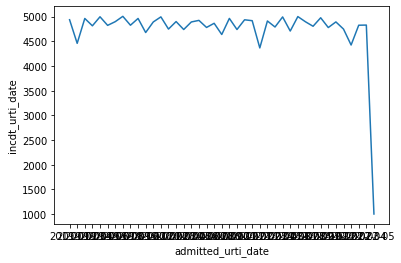

In [109]:
sns.lineplot(y=df.incdt_urti_date, x=df.index)
#denuminator: number of hosp for infection in a given time point (numenator) over total nmumber of patient registered

In [67]:
def create_lineplot(data, var, title, legend_title, ax1):
    a = data.groupby(['date', var]).size().reset_index()
    a.columns = ['date', var, 'Freq']
    a.Freq = a.Freq /1000
    sns.lineplot(x='date', y='Freq', 
            hue=var, 
            data=a,
            ax=ax1)
    ax1.set_title(title)
    ax1.set_ylabel('Count in 1000 patients')
    ax1.xaxis.set_tick_params(which='both', labelbottom=True, labeltop=False, rotation=90)
    ax1.legend(title=legend_title)
    ax1.grid()
    ax1.axvline(x="2020-01", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2020-04", color='black', ls='--', lw=1.5)
    ax1.axvline(x="2021-04", color='black', ls='--', lw=1.5)

,urti_date,incdt_urti_date,admitted_urti_date,sgss_gp_cov_urti_date
0,NaN,0,6,0
1,NaN,0,6,0
2,NaN,0,12,0
3,2020-07-30,0,3,0
4,NaN,0,2,0
...,...,...,...,...
215947,NaN,1,10,0
215948,NaN,0,7,0
215949,2021-01-04,0,11,0
215950,NaN,0,4,0


In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))

create_lineplot('Infection_admitted_min_delta_delta_sgss_covid_admitted_binary', 'Infection-related hospital admission without Covid19 diagnosis', 'Hospitalisation', ax)

plt.tight_layout()
#plt.savefig('../output/hospitalisation_risk/infection-related_hospitalisation.jpg')
plt.show()

## 3- Data preparation
This includes data type conversion and exclusion of cases that are not considered in the infection-related hospital admission, i.e. those who were diagnosed with Covid19 three months (=90 days) before and one month (=30 days) after hospital admission.

### 3-1- URTI

#### URTI-1

In [93]:
data_urti_1 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat', 'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_1', 'gp_cons_urti_ab_1',
                    'urti_date_1', 'incdt_urti_date_1', 'admitted_urti_date_1', 'sgss_gp_cov_urti_date_1']]

data_urti_1 = data_urti_1[data_urti_1['urti_date_1'].notnull()]

data_urti_1.shape

(19859, 31)

In [94]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_1
data_urti_1 = data_urti_1[data_urti_1['sgss_gp_cov_urti_date_1'] == 0]
data_urti_1.shape

(17875, 31)

In [95]:
data_urti_1.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti_1', 'gp_cons_urti_ab_1',
       'urti_date_1', 'incdt_urti_date_1', 'admitted_urti_date_1',
       'sgss_gp_cov_urti_date_1'],
      dtype='object')

In [96]:
# drop rows with no gp_cons_urti_1 records
data_urti_1 = data_urti_1.dropna(subset=['gp_cons_urti_1'])
data_urti_1.shape

(1885, 31)

#### URTI-2

In [97]:
data_urti_2 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat', 'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_2', 'gp_cons_urti_ab_2',
                    'urti_date_2', 'incdt_urti_date_2', 'admitted_urti_date_2', 'sgss_gp_cov_urti_date_2']]

data_urti_2 = data_urti_2[data_urti_2['urti_date_2'].notnull()]

data_urti_2.shape

(19879, 31)

In [98]:
data_urti_1.urti_date_1.value_counts()

2021-08-22    8
2020-10-18    6
2020-06-14    6
2019-09-24    6
2021-11-22    6
             ..
2021-11-07    1
2020-07-10    1
2022-02-07    1
2022-04-03    1
2019-08-19    1
Name: urti_date_1, Length: 960, dtype: int64

In [99]:
data_urti_2.urti_date_2.value_counts()

2020-07-04    31
2019-07-22    31
2019-10-02    29
2020-05-08    29
2019-12-22    29
              ..
2021-01-15     6
2019-08-08     5
2021-01-14     4
2021-09-11     4
2019-12-24     4
Name: urti_date_2, Length: 1210, dtype: int64

In [100]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_2
data_urti_2 = data_urti_2[data_urti_2['sgss_gp_cov_urti_date_2'] == 0]
data_urti_2.shape

(17892, 31)

In [101]:
data_urti_2.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti_2', 'gp_cons_urti_ab_2',
       'urti_date_2', 'incdt_urti_date_2', 'admitted_urti_date_2',
       'sgss_gp_cov_urti_date_2'],
      dtype='object')

In [102]:
# drop rows with no gp_cons_urti_2 records
data_urti_2 = data_urti_2.dropna(subset=['gp_cons_urti_2'])
data_urti_2.shape

(1780, 31)

#### URTI_3

In [103]:
data_urti_3 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat', 'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_3', 'gp_cons_urti_ab_3',
                    'urti_date_3', 'incdt_urti_date_3', 'admitted_urti_date_3', 'sgss_gp_cov_urti_date_3']]

data_urti_3 = data_urti_3[data_urti_3['urti_date_3'].notnull()]

data_urti_3.shape

(19892, 31)

In [104]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_3
data_urti_3 = data_urti_3[data_urti_3['sgss_gp_cov_urti_date_3'] == 0]
data_urti_3.shape

(17893, 31)

In [105]:
data_urti_3.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti_3', 'gp_cons_urti_ab_3',
       'urti_date_3', 'incdt_urti_date_3', 'admitted_urti_date_3',
       'sgss_gp_cov_urti_date_3'],
      dtype='object')

In [106]:
# drop rows with no gp_cons_urti_3 records
data_urti_3 = data_urti_3.dropna(subset=['gp_cons_urti_3'])
data_urti_3.shape

(1745, 31)

#### URTI_4

In [107]:
data_urti_4 = data[['Age_cat', 'msoa', #'date',
                    'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat', 'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine', 
                    'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp', 'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
                    'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',  #'season', 
                    'died_date', 'deregistered_date', 'gp_cons_urti_4', 'gp_cons_urti_ab_4',
                    'urti_date_4', 'incdt_urti_date_4', 'admitted_urti_date_4', 'sgss_gp_cov_urti_date_4']]

data_urti_4 = data_urti_4[data_urti_4['urti_date_4'].notnull()]

data_urti_4.shape

(19873, 31)

In [108]:
# exclusion of covid positive 90 days before and 30 days after dx with urti_4
data_urti_4 = data_urti_4[data_urti_4['sgss_gp_cov_urti_date_4'] == 0]
data_urti_4.shape

(17875, 31)

In [109]:
data_urti_4.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti_4', 'gp_cons_urti_ab_4',
       'urti_date_4', 'incdt_urti_date_4', 'admitted_urti_date_4',
       'sgss_gp_cov_urti_date_4'],
      dtype='object')

In [110]:
data_urti_4.shape

(17875, 31)

In [111]:
# data_urti_4.gp_cons_urti_4.value_counts()#isnull().sum()
data_urti_4.gp_cons_urti_4.isnull().sum()

16152

In [112]:
# drop rows with no gp_cons_urti_4 records
data_urti_4 = data_urti_4.dropna(subset=['gp_cons_urti_4'])
data_urti_4.shape

(1723, 31)

#### Combining URTI_1, URTI_2, URTI_3, and URTI_4

In [113]:
data_urti_1.rename(columns={'urti_date_1': 'urti_date',
                           'gp_cons_urti_1': 'gp_cons_urti', 'gp_cons_urti_ab_1': 'gp_cons_urti_ab',
                           'incdt_urti_date_1': 'incdt_urti_date', #'prevl_urti_date_1': 'prevl_urti_date',
                           'admitted_urti_date_1': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_1': 'sgss_gp_cov_urti_date'},
                inplace=True)
data_urti_2.rename(columns={'urti_date_2': 'urti_date',
                           'gp_cons_urti_2': 'gp_cons_urti', 'gp_cons_urti_ab_2': 'gp_cons_urti_ab',
                           'incdt_urti_date_2': 'incdt_urti_date', #'prevl_urti_date_2': 'prevl_urti_date', 
                           'admitted_urti_date_2': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_2': 'sgss_gp_cov_urti_date'},
                inplace=True)
data_urti_3.rename(columns={'urti_date_3': 'urti_date',
                           'gp_cons_urti_3': 'gp_cons_urti', 'gp_cons_urti_ab_3': 'gp_cons_urti_ab',
                           'incdt_urti_date_3': 'incdt_urti_date', #'prevl_urti_date_3': 'prevl_urti_date', 
                           'admitted_urti_date_3': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_3': 'sgss_gp_cov_urti_date'},
                 inplace=True)
data_urti_4.rename(columns={'urti_date_4': 'urti_date', 
                           'gp_cons_urti_4': 'gp_cons_urti', 'gp_cons_urti_ab_4': 'gp_cons_urti_ab',
                           'incdt_urti_date_4': 'incdt_urti_date', #'prevl_urti_date_4': 'prevl_urti_date',
                           'admitted_urti_date_4': 'admitted_urti_date',
                           'sgss_gp_cov_urti_date_4': 'sgss_gp_cov_urti_date'}, 
                 inplace=True)

data_urti = pd.concat([data_urti_1, data_urti_2, data_urti_3, data_urti_4])
data_urti.reset_index(inplace=True, drop=True)
data_urti.shape

(7133, 31)

In [114]:
data_urti_4.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab',
       'urti_date', 'incdt_urti_date', 'admitted_urti_date',
       'sgss_gp_cov_urti_date'],
      dtype='object')

In [115]:
data_urti['urti_date'] = data_urti['urti_date'].astype('datetime64[ns]')
data_urti['gp_cons_urti'] = data_urti['gp_cons_urti'].astype('datetime64[ns]')
data_urti['admitted_urti_date'] = data_urti['admitted_urti_date'].astype('datetime64[ns]')
data_urti.died_date = data_urti.died_date.astype('datetime64[ns]')
data_urti.deregistered_date = data_urti.deregistered_date.astype('datetime64[ns]')
data_urti.shape

(7133, 31)

In [116]:
#add a variable called date using gp consultation dates
data_urti['date'] = data_urti['gp_cons_urti']
data_urti['date'] = data_urti['date'].dt.strftime('%Y-%m')

In [117]:
#add a variable called season based on the month of urti records
data_urti['season'] = np.nan
data_urti['date_month'] = pd.DatetimeIndex(data_urti['date']).month

conditions = [
    (data_urti['date_month'] >= 3) & (data_urti['date_month'] <= 5),
    (data_urti['date_month'] >= 6) & (data_urti['date_month'] <= 8),
    (data_urti['date_month'] >= 9) & (data_urti['date_month'] <= 11),]
choices = ['Spring', 'Summer', 'Autumn']
data_urti['season'] = np.select(conditions, choices, default='Winter')

data_urti['season'].value_counts()

Spring    2018
Winter    1860
Summer    1640
Autumn    1615
Name: season, dtype: int64

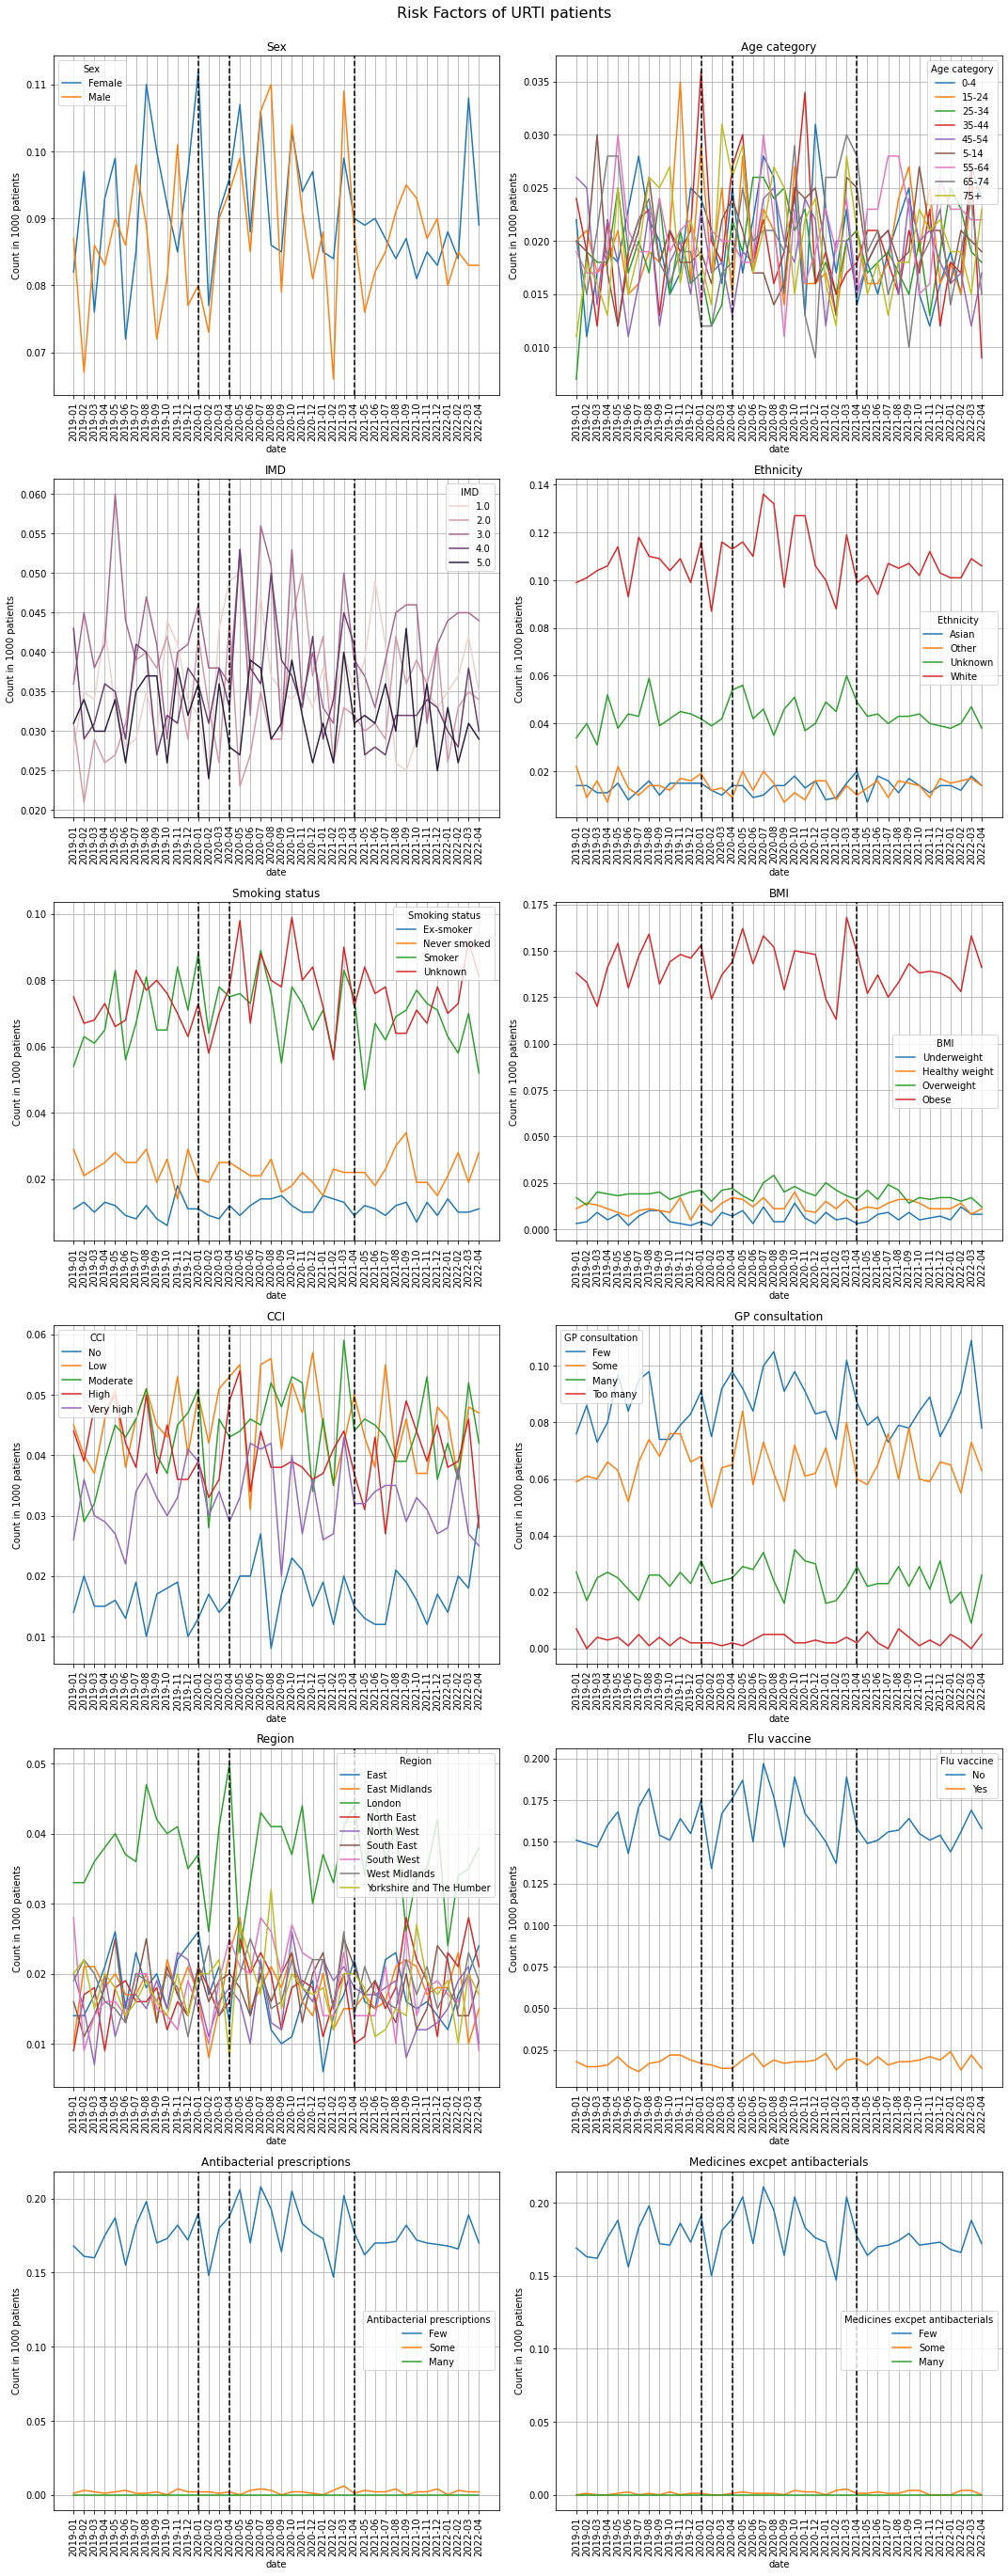

In [118]:
fig, axes = plt.subplots(6,2,
                        figsize=(15, 40)
                        )
create_lineplot(data_urti, 'sex', 'Sex', 'Sex', axes[0,0])
create_lineplot(data_urti, 'age_cat', 'Age category', 'Age category', axes[0,1])
create_lineplot(data_urti, 'imd_imp', 'IMD', 'IMD', axes[1,0])
create_lineplot(data_urti, 'ethnicity_imp', 'Ethnicity', 'Ethnicity', axes[1,1])
create_lineplot(data_urti, 'smoking_status_imp', 'Smoking status', 'Smoking status', axes[2,0])
create_lineplot(data_urti, 'bmi_imp_cat', 'BMI', 'BMI', axes[2,1])
create_lineplot(data_urti, 'CCI_cat', 'CCI', 'CCI', axes[3,0])
create_lineplot(data_urti, 'gp_count_imp_cat', 'GP consultation', 'GP consultation', axes[3,1])
create_lineplot(data_urti, 'region_imp', 'Region', 'Region', axes[4,0])
create_lineplot(data_urti, 'flu_vaccine', 'Flu vaccine', 'Flu vaccine', axes[4,1])
create_lineplot(data_urti, 'antibacterial_brit_cat', 'Antibacterial prescriptions', 'Antibacterial prescriptions', axes[5,0])
# create_lineplot(data_urti, 'msoa', 'msoa', 'MSOA', axes[5,1])
create_lineplot(data_urti, 'meds_nonabs_cat', 'Medicines excpet antibacterials', 'Medicines excpet antibacterials', axes[5,1])
# fig.delaxes(ax=axes[6,1])

fig.suptitle('Risk Factors of URTI patients', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.98])
#plt.tight_layout()
# plt.savefig('../output/hospitalisation_prediction_urti/risk_factors_cat_urti.jpg')
plt.show()

#### Adding event and duration columns

In [119]:
#scenario 1
#not hosped (nothing happened)
#data_urti = data_urti[data_urti['admitted_urti_date'].notnull()]
data_urti.loc[data_urti['admitted_urti_date'].isnull(), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    4953
Name: event_urti_admitted, dtype: int64

In [120]:
#scenario 2 
# become a case (uncensoring)
#calculating days between infection gp consultation and hosp
# data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['urti_date']).dt.days
data_urti['delta_urti_admitted'] = (data_urti['admitted_urti_date'] - data_urti['gp_cons_urti']).dt.days
data_urti.loc[((data_urti['delta_urti_admitted'] >= 0) & (data_urti['delta_urti_admitted'] <= 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    4953
1.0      51
Name: event_urti_admitted, dtype: int64

In [121]:
#scenario 2
#drop whoever was admitted before urti consultation, i.e. negative value for delta_urti_admitted
data_urti = data_urti[~(data_urti['delta_urti_admitted'] < 0)]
data_urti['delta_urti_admitted'].value_counts()

243.0     7
100.0     6
159.0     6
337.0     5
40.0      5
         ..
621.0     1
637.0     1
442.0     1
1034.0    1
505.0     1
Name: delta_urti_admitted, Length: 642, dtype: int64

In [122]:
# data_urti['event_urti_admitted'].value_counts()
data_urti['event_urti_admitted'].isnull().sum()

1065

In [123]:
#scenario 3
#censor died patients
data_urti['delta_admitted_died'] = (data_urti['died_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_died'] < 0, 'delta_admitted_died'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_died'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_died'] >= 0) & (data_urti['delta_admitted_died'] <= 30)), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    4961
1.0      50
Name: event_urti_admitted, dtype: int64

In [124]:
#scenario 3
#censor deregistered patients
data_urti['delta_admitted_deregistered'] = (data_urti['deregistered_date'] - data_urti['admitted_urti_date']).dt.days
data_urti.loc[data_urti['delta_admitted_deregistered'] < 0, 'delta_admitted_deregistered'] = np.NaN
# data_urti.loc[data_urti['delta_admitted_deregistered'] >= 0, 'event_urti_admitted'] = 0
data_urti.loc[((data_urti['delta_admitted_deregistered'] > 0) & (data_urti['delta_admitted_deregistered'] <= 30)), 'event_urti_admitted'] = 0
data_urti['event_urti_admitted'].value_counts()

0.0    4961
1.0      50
Name: event_urti_admitted, dtype: int64

In [125]:
#agg scenario 3s
data_urti['delta_admitted_died_deregistered'] = data_urti['delta_admitted_deregistered'].combine_first(data_urti['delta_admitted_died'])
data_urti.loc[data_urti['delta_admitted_died_deregistered'] < 0, 'delta_admitted_died_deregistered'] = np.NaN
data_urti['delta_admitted_died_deregistered'].isnull().sum()#.value_counts()

5965

In [126]:
data_urti['delta_admitted_died_deregistered'].value_counts()

157.0    2
34.0     2
59.0     2
130.0    1
234.0    1
        ..
205.0    1
361.0    1
113.0    1
587.0    1
796.0    1
Name: delta_admitted_died_deregistered, Length: 101, dtype: int64

In [127]:
#censor patients that had a history of hospital admission
# data_urti.loc[data_urti['hx_hosp'] == 1, 'event_urti_admitted'] = 0

In [128]:
#scenario 1
#any other patients (nothing happened)
data_urti['event_urti_admitted'] = data_urti['event_urti_admitted'].replace(np.NaN, 0)
data_urti['event_urti_admitted'].value_counts()

0.0    6019
1.0      50
Name: event_urti_admitted, dtype: int64

In [129]:
#assign values for duration column
data_urti['duration_urti_admitted'] = data_urti['delta_urti_admitted'].combine_first(data_urti['delta_admitted_died_deregistered'])
data_urti['duration_urti_admitted'] = data_urti['duration_urti_admitted'].replace(np.NaN, 30)
data_urti.loc[(data_urti['duration_urti_admitted'] > 30), 'duration_urti_admitted'] = 30
data_urti['duration_urti_admitted'].value_counts()

30.0    6018
1.0        4
26.0       4
13.0       4
6.0        4
14.0       3
9.0        3
27.0       3
17.0       3
21.0       3
18.0       3
8.0        3
22.0       2
20.0       2
7.0        2
15.0       1
25.0       1
4.0        1
16.0       1
2.0        1
19.0       1
29.0       1
12.0       1
Name: duration_urti_admitted, dtype: int64

In [130]:
# give value 1 to event_urti_admitted if duration_urti_admitted is greater or equal to 0 and less than 30
data_urti.loc[((data_urti['duration_urti_admitted'] >= 0) & (data_urti['duration_urti_admitted'] < 30)), 'event_urti_admitted'] = 1
data_urti['event_urti_admitted'].value_counts()

0.0    6018
1.0      51
Name: event_urti_admitted, dtype: int64

In [131]:
#drop any rows with value 0 in duration column
data_urti = data_urti[~(data_urti['duration_urti_admitted'] == 0)]

In [132]:
data_urti[data_urti['duration_urti_admitted']==0][['delta_urti_admitted', 'urti_date', 'gp_cons_urti', 'admitted_urti_date', 'delta_urti_admitted', 'delta_admitted_died_deregistered', 'event_urti_admitted', 'duration_urti_admitted']]

,delta_urti_admitted,urti_date,gp_cons_urti,admitted_urti_date,delta_urti_admitted,delta_admitted_died_deregistered,event_urti_admitted,duration_urti_admitted


In [133]:
#scenario2 (uncensoring) again to prevent conflict with other scenarios
data_urti.loc[((data_urti['delta_urti_admitted'] > 0) & (data_urti['delta_urti_admitted'] < 30)), 'event_urti_admitted'] = 1

In [134]:
# data_urti['duration_urti_admitted'].value_counts()

In [135]:
# data_urti.loc[151:200, ['event_urti_admitted', 'duration_urti_admitted']]
# data_urti.loc[201:250, ['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])
data_urti[['event_urti_admitted', 'duration_urti_admitted']].sort_values(by=['duration_urti_admitted'])

,event_urti_admitted,duration_urti_admitted
1674,1.0,1.0
5843,1.0,1.0
4609,1.0,1.0
7042,1.0,1.0
5702,1.0,2.0
...,...,...
2391,0.0,30.0
2390,0.0,30.0
2389,0.0,30.0
2399,0.0,30.0


#### Separate data of URTI
We separate data of urti to form four sub-datasets for 1) no antibiotics and incident admission, 2) with antibiotics and incident admission, 3) no antibiotics and prevalent admission, and 4) with antiobiotics and prevalent admission.

In [136]:
# no antibiotics and incident hospital admission
data_urti_no_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_incdt = data_urti_no_abs_incdt[data_urti_no_abs_incdt['incdt_urti_date'] == 0]

# with antibiotics and incident hospital admission
data_urti_abs_incdt = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_incdt = data_urti_abs_incdt[data_urti_abs_incdt['incdt_urti_date'] == 0]

# no antibiotics and prevalent hospital admission
data_urti_no_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].isnull()]
data_urti_no_abs_prevl = data_urti_no_abs_prevl[data_urti_no_abs_prevl['incdt_urti_date'] == 1]

# with antibiotics and prevalent hospital admission
data_urti_abs_prevl = data_urti[data_urti['gp_cons_urti_ab'].notnull()]
data_urti_abs_prevl = data_urti_abs_prevl[data_urti_abs_prevl['incdt_urti_date'] == 1]

print(f'shape of data_urti_no_abs_incdt: {data_urti_no_abs_incdt.shape}')
print(f'shape of data_urti_abs_incdt: {data_urti_abs_incdt.shape}')
print(f'shape of data_urti_no_abs_prevl: {data_urti_no_abs_prevl.shape}')
print(f'shape of data_urti_abs_prevl: {data_urti_abs_prevl.shape}')

shape of data_urti_no_abs_incdt: (4895, 40)
shape of data_urti_abs_incdt: (560, 40)
shape of data_urti_no_abs_prevl: (554, 40)
shape of data_urti_abs_prevl: (60, 40)


## 4- Cox modelling for hospital admissions related to infections 
### 4-1- URTI
#### 4-1-1- Incident hospital admission related to URTI with no antibiotics

In [137]:
data_urti_no_abs_incdt.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab',
       'urti_date', 'incdt_urti_date', 'admitted_urti_date',
       'sgss_gp_cov_urti_date', 'date', 'season', 'date_month',
       'event_urti_admitted', 'delta_urti_admitted', 'delta_admitted_died',
       'delta_admitted_deregistered', 'delta_admitted_died_deregistered',
       'duration_urti_admitted'],
      dtype='object')

In [138]:
data_urti_no_abs_incdt.shape

(4895, 40)

In [139]:
#keep relevant variables
data_urti_no_abs_incdt = data_urti_no_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat', 
                                                 'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp', 'season', 
                                                 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'antibacterial_brit_cat',
                                                 'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat',
                                                 'event_urti_admitted', 'duration_urti_admitted']]

In [140]:
# printing number of missing values in each variable 
data_urti_no_abs_incdt.isnull().sum()

age_cat                   0
sex                       0
CCI_cat                   0
age                       0
bmi_imp                   0
bmi_imp_cat               2
gp_count_imp              0
gp_count_imp_cat          0
flu_vaccine               0
region_imp                0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
antibacterial_brit_cat    0
smoking_status_imp        0
meds_nonabs               0
meds_nonabs_cat           0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [141]:
# #drop ros with missing values
# data_urti_no_abs_incdt = data_urti_no_abs_incdt.dropna(axis='rows')
# # data_urti = data_urti.drop(columns=['smoking_status'])
# data_urti_no_abs_incdt.isnull().sum()

In [142]:
data_urti_no_abs_incdt.columns

Index(['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat',
       'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp',
       'season', 'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp',
       'antibacterial_brit_cat', 'smoking_status_imp', 'meds_nonabs',
       'meds_nonabs_cat', 'event_urti_admitted', 'duration_urti_admitted'],
      dtype='object')

In [156]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_no_abs_incdt_train, data_urti_no_abs_incdt_test = train_test_split(data_urti_no_abs_incdt, test_size=0.2)

print(f'shape of data_urti_no_abs_incdt for training: {data_urti_no_abs_incdt_train.shape}')
print(f'shape of data_urti_no_abs_incdt for testing: {data_urti_no_abs_incdt_test.shape}')

shape of data_urti_no_abs_incdt for training: (3916, 20)
shape of data_urti_no_abs_incdt for testing: (979, 20)


In [146]:
cph_urti_no_abs_incdt = CoxPHFitter()
cph_urti_no_abs_incdt.fit(data_urti_no_abs_incdt_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + gp_count_imp_cat + flu_vaccine"# + bmi_imp_cat + region"# bmi_imp + antibacterial_brit_imp + imd_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # season +
        # formula="age_cat + sex + CCI_cat + bmi_imp + gp_count_imp"# + flu_vaccine + region_imp + imd_imp + ethnicity_imp + smoking_status_imp + season"# + antibacterial_brit_imp + meds_nonabs_cat"
        #, show_progress=True
        #, step_size=0.01
        )
cph_urti_no_abs_incdt.print_summary()
# cph_urti_no_abs_incdt_summary = cph_urti_no_abs_incdt.print_summary(style="html")
# cph_urti_no_abs_incdt.print_summary(columns=["coef", "se(coef)", "p"])

<lifelines.CoxPHFitter: fitted with 3916 total observations, 3882 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 3916
number of events observed = 34
   partial log-likelihood = -273.49
         time fit was run = 2022-04-28 14:20:18 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                            
CCI_cat[T.Low]                -0.21       0.81       0.54            -1.27             0.86                 0.28                 2.35
CCI_cat[T.Moderate]           -1.21       0.30       0.67            -2.53             0.11                 0.08                 1.11
CCI_cat[T.High]               -0.45       0.64       0.57            -1.57             0.67                 0.21                 1.96
CCI_cat[T.Very high]          -0.47       0.63       0.61            -1.66             0.72                 0.19                 2.06
age_cat[T.15-24]               0.31       1.36       0.76            -1.19             1.81                 0.30                 6.09
age_cat[T.25-34]               0.63       1.88       0.73            -0.80             2.07                 0.45                 7.89
age_cat[T.35-44]               0.11       1.11       0.82            -1.49             1.71                 0.22                 5.53
age_cat[T.45-54]               0.16       1.17       0.82            -1.44             1.76                 0.24                 5.83
age_cat[T.5-14]                0.56       1.75       0.73            -0.87             2.00                 0.42                 7.36
age_cat[T.55-64]               0.29       1.34       0.76            -1.21             1.79                 0.30                 5.98
age_cat[T.65-74]              -1.13       0.32       1.16            -3.40             1.14                 0.03                 3.11
age_cat[T.75+]                 0.72       2.05       0.71            -0.67             2.10                 0.51                 8.20
flu_vaccine[T.Yes]             0.16       1.17       0.53            -0.89             1.21                 0.41                 3.35
gp_count_imp_cat[T.Some]       0.04       1.04       0.37            -0.68             0.77                 0.51                 2.15
gp_count_imp_cat[T.Many]      -0.36       0.70       0.63            -1.59             0.87                 0.20                 2.40
gp_count_imp_cat[T.Too many]   0.67       1.95       1.03            -1.36             2.69                 0.26                14.73
sex[T.Male]                   -0.74       0.48       0.37            -1.46            -0.02                 0.23                 0.98

                               cmp to     z    p   -log2(p)
covariate                                                  
CCI_cat[T.Low]                   0.00 -0.38 0.70       0.50
CCI_cat[T.Moderate]              0.00 -1.80 0.07       3.81
CCI_cat[T.High]                  0.00 -0.78 0.43       1.20
CCI_cat[T.Very high]             0.00 -0.77 0.44       1.19
age_cat[T.15-24]                 0.00  0.40 0.69       0.54
age_cat[T.25-34]                 0.00  0.86 0.39       1.37
age_cat[T.35-44]                 0.00  0.13 0.89       0.16
age_cat[T.45-54]                 0.00  0.20 0.85       0.24
age_cat[T.5-14]                  0.00  0.77 0.44       1.18
age_cat[T.55-64]                 0.00  0.38 0.70       0.51
age_cat[T.65-74]                 0.00 -0.98 0.33       1.61
age_cat[T.75+]                   0.00  1.01 0.31       1.68
flu_vaccine[T.Yes]               0.00  0.30 0.76       0.39
gp_count_imp_cat[T.Some]         0.00  0.11 0.91       0.14
gp_count_imp_cat[T.Many]         0.00 -0.57 0.57       0.81
gp_count_imp_cat[T.Too many]     0.00  0.6

In [174]:
# print(cph_urti_no_abs_incdt.score(data_urti_no_abs_incdt_1_test))
# print(cph_urti_no_abs_incdt.concordance_index_)
# print(cph_urti_no_abs_incdt.AIC_partial_)
# print(cph_urti_no_abs_incdt.concordance_index_)

#### 4-1-2- Incident hospital admission related to URTI with antibiotics

In [154]:
data_urti_abs_incdt.columns

Index(['Age_cat', 'msoa', 'age', 'age_cat', 'sex', 'bmi_imp', 'bmi_imp_cat',
       'gp_count', 'gp_count_imp_cat', 'gp_count_imp', 'flu_vaccine',
       'region_imp', 'smoking_status_imp', 'antibacterial_brit', 'imd_imp',
       'ethnicity_imp', 'antibacterial_brit_imp', 'antibacterial_brit_cat',
       'hx_hosp', 'CCI_cat', 'CCI', 'meds_nonabs', 'meds_nonabs_cat',
       'died_date', 'deregistered_date', 'gp_cons_urti', 'gp_cons_urti_ab',
       'urti_date', 'incdt_urti_date', 'admitted_urti_date',
       'sgss_gp_cov_urti_date', 'date', 'season', 'date_month',
       'event_urti_admitted', 'delta_urti_admitted', 'delta_admitted_died',
       'delta_admitted_deregistered', 'delta_admitted_died_deregistered',
       'duration_urti_admitted'],
      dtype='object')

In [155]:
data_urti_abs_incdt.shape

(560, 40)

In [126]:
#keep relevant variables
data_urti_abs_incdt = data_urti_abs_incdt[['age_cat', 'sex', 'CCI_cat', 'age', 'bmi_imp', 'bmi_imp_cat', 
                                           'gp_count_imp', 'gp_count_imp_cat', 'flu_vaccine', 'region_imp', 'season', 
                                           'imd_imp', 'antibacterial_brit_imp', 'ethnicity_imp', 'antibacterial_brit_cat',
                                           'smoking_status_imp', 'meds_nonabs', 'meds_nonabs_cat',
                                           'event_urti_admitted', 'duration_urti_admitted']]

In [127]:
# printing number of missing values in each variable 
data_urti_abs_incdt.isnull().sum()

age_cat                   0
CCI_cat                   0
age                       0
bmi_imp                   0
gp_count_imp              0
flu_vaccine               0
sex                       0
region_imp                0
season                    0
imd_imp                   0
antibacterial_brit_imp    0
ethnicity_imp             0
antibacterial_brit_cat    0
smoking_status_imp        0
meds_nonabs               0
meds_nonabs_cat           0
event_urti_admitted       0
duration_urti_admitted    0
dtype: int64

In [128]:
# #drop ros with missing values
# data_urti_abs_incdt = data_urti_abs_incdt.dropna(axis='rows')
# #data_urti_abs_incdt = data_urti_abs_incdt.drop(columns=['smoking_status'])
# data_urti_abs_incdt.isnull().sum()

In [157]:
#randomly splitting data into training (%75) and testing (%25)
data_urti_abs_incdt_train, data_urti_abs_incdt_test = train_test_split(data_urti_abs_incdt, test_size=0.2)

print(f'shape of data_urti_abs_incdt for training: {data_urti_abs_incdt_train.shape}')
print(f'shape of data_urti_abs_incdt for testing: {data_urti_abs_incdt_test.shape}')

shape of data_urti_abs_incdt for training: (448, 40)
shape of data_urti_abs_incdt for testing: (112, 40)


In [158]:
cph_urti_abs_incdt = CoxPHFitter().fit(data_urti_abs_incdt_train,
        duration_col='duration_urti_admitted',
        event_col='event_urti_admitted',
        formula="age_cat + sex + CCI_cat + gp_count_imp_cat + flu_vaccine"# + region + antibacterial_brit_imp + imd_imp + ethnicity_imp + smoking_status_imp + meds_nonabs" # season +
        )
cph_urti_abs_incdt.print_summary()

<lifelines.CoxPHFitter: fitted with 448 total observations, 443 right-censored observations>
             duration col = 'duration_urti_admitted'
                event col = 'event_urti_admitted'
      baseline estimation = breslow
   number of observations = 448
number of events observed = 5
   partial log-likelihood = -24.27
         time fit was run = 2022-04-28 14:27:42 UTC

---
                               coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                            
CCI_cat[T.Low]                17.37   3.49e+07    7068.14        -13835.94         13870.67                 0.00                  inf
CCI_cat[T.Moderate]           16.76   1.90e+07    7068.14        -13836.55         13870.06                 0.00                  inf
CCI_cat[T.High]               18.11   7.31e+07    7068.14        -13835.20         13871.41                 0.00                  inf
CCI_cat[T.Very high]          -0.17       0.85    8764.59        -17178.45         17178.12                 0.00                  inf
age_cat[T.15-24]             -18.29       0.00    6685.77        -13122.15         13085.57                 0.00                  inf
age_cat[T.25-34]             -18.12       0.00    7026.86        -13790.52         13754.28                 0.00                  inf
age_cat[T.35-44]             -18.05       0.00    6895.09        -13532.18         13496.09                 0.00                  inf
age_cat[T.45-54]              -0.25       0.78       1.48            -3.14             2.64                 0.04                14.02
age_cat[T.5-14]              -18.28       0.00    7339.86        -14404.14         14367.58                 0.00                  inf
age_cat[T.55-64]              -0.43       0.65       1.45            -3.27             2.41                 0.04                11.11
age_cat[T.65-74]              -0.49       0.61       1.47            -3.37             2.39                 0.03                10.97
age_cat[T.75+]                -0.53       0.59       1.51            -3.48             2.42                 0.03                11.29
flu_vaccine[T.Yes]             1.44       4.24       1.25            -1.01             3.90                 0.37                49.18
gp_count_imp_cat[T.Some]      -1.12       0.33       1.19            -3.45             1.22                 0.03                 3.38
gp_count_imp_cat[T.Many]      -0.25       0.78       1.21            -2.63             2.13                 0.07                 8.40
gp_count_imp_cat[T.Too many] -17.91       0.00   15973.74        -31325.87         31290.04                 0.00                  inf
sex[T.Male]                    0.28       1.33       0.93            -1.53             2.10                 0.22                 8.16

                               cmp to     z    p   -log2(p)
covariate                                                  
CCI_cat[T.Low]                   0.00  0.00 1.00       0.00
CCI_cat[T.Moderate]              0.00  0.00 1.00       0.00
CCI_cat[T.High]                  0.00  0.00 1.00       0.00
CCI_cat[T.Very high]             0.00 -0.00 1.00       0.00
age_cat[T.15-24]                 0.00 -0.00 1.00       0.00
age_cat[T.25-34]                 0.00 -0.00 1.00       0.00
age_cat[T.35-44]                 0.00 -0.00 1.00       0.00
age_cat[T.45-54]                 0.00 -0.17 0.87       0.21
age_cat[T.5-14]                  0.00 -0.00 1.00       0.00
age_cat[T.55-64]                 0.00 -0.30 0.77       0.38
age_cat[T.65-74]                 0.00 -0.33 0.74       0.43
age_cat[T.75+]                   0.00 -0.35 0.73       0.46
flu_vaccine[T.Yes]               0.00  1.15 0.25       2.01
gp_count_imp_cat[T.Some]         0.00 -0.94 0.35       1.52
gp_count_imp_cat[T.Many]         0.00 -0.21 0.84       0.26
gp_count_imp_cat[T.Too many]     0.00 -0.00 1.0